In [1]:
!pip install torch_geometric
import torch
import torch.nn as nn
from torch import optim
from torch_geometric.datasets import Planetoid
from torch_geometric.datasets import TUDataset
from torch_geometric.nn import GCNConv
from torch_geometric.nn import GATConv
from torch_geometric.nn import global_mean_pool
from torch_geometric.data import Data
from torch_geometric.datasets import PPI
from torch_geometric.utils import to_networkx
from torch_geometric.loader import DataLoader
import networkx as nx
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 7.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch_geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910454 sha256=0ee58f2b8aa3ddfe2cf14fcf1a5b5ab51a423ef3b51adf0ca68e1b035c698a7e
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
Successfully built torch_geometric


In [2]:
dataset = Planetoid(root='/tmp/Cora', name='Cora')#グラフデータのダウンロード
def graph_info(data):#グラフ情報の取得
  print('ノード数:',data.num_nodes)
  print('エッジ数:',data.num_edges)
  print('特徴量の数:',data.num_edge_features)
  print('無効グラフかどうか:',data.is_undirected())
  print('孤立したノードがあるか:',data.has_isolated_nodes())
  print('自己ループがあるか:',data.has_self_loops())

Processing...
Done!


In [3]:
data=dataset[0]
graph_info(data)

ノード数: 2708
エッジ数: 10556
特徴量の数: 0
無効グラフかどうか: True
孤立したノードがあるか: False
自己ループがあるか: False


In [4]:
dataset.num_classes#データのクラス数

7

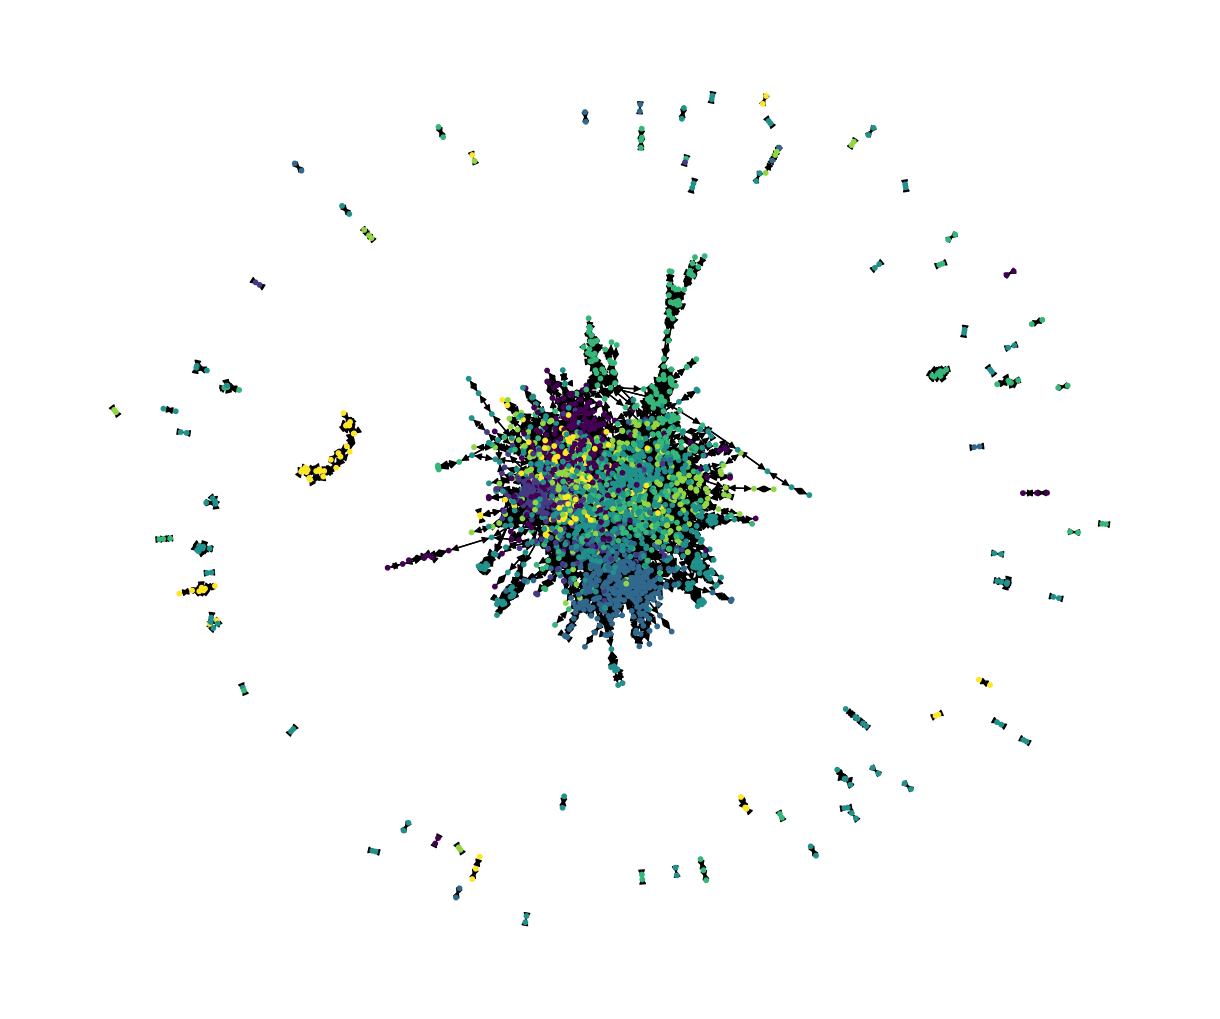

In [5]:
#グラフの可視化
nxg=to_networkx(data)
plt.figure(figsize=(12,10))
nx.draw(nxg,node_size=10,node_color=data.y)#data.yはデータのラベル
plt.show()

In [6]:
class GCN(nn.Module): #２層GCNモデルの構築
  def __init__(self):
    super().__init__()
    self.conv1=GCNConv(dataset.num_node_features,32)
    self.relu=nn.ReLU()
    self.conv2=GCNConv(32,dataset.num_classes)

  def forward(self,data):
    x=data.x #各ノードの特徴量
    edge_index=data.edge_index #各エッジがどのノードからどのノードへとつながっているかについてのテンソル
    x = self.conv1(x, edge_index)
    x = self.relu(x)
    x = self.conv2(x, edge_index)

    return x

net=GCN()

In [7]:
#モデルの学習
loss_func=nn.CrossEntropyLoss() #損失関数
optimizer=optim.Adam(net.parameters()) #最適化アルゴリズム
net.train() #訓練モード
for epoch in range(200):
  optimizer.zero_grad() #①勾配初期化
  out=net(data) #②順伝播による予測
  loss=loss_func(out[data.train_mask],data.y[data.train_mask]) #③誤差を計算
  loss.backward() #④逆伝播で勾配計算
  optimizer.step() #⑤パラメータ更新

In [8]:
#モデルの評価
net.eval() #評価モード
pred=net(data).argmax(dim=1)
correct=(pred[data.test_mask]==data.y[data.test_mask]).sum()
accuracy=int(correct)/int(data.test_mask.sum())
print('正解率:',str(accuracy*100)+'%')

正解率: 79.3%


In [9]:
dataset=TUDataset(root='/tmp/MUTAG',name='MUTAG')
print('グラフの数:',len(dataset))
print('クラスの数:',dataset.num_classes)

data2=dataset[0]
data2

Extracting /tmp/MUTAG/MUTAG/MUTAG.zip
Processing...


グラフの数: 188
クラスの数: 2


Done!


Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])

In [10]:
graph_info(data2)

ノード数: 17
エッジ数: 38
特徴量の数: 4
無効グラフかどうか: True
孤立したノードがあるか: False
自己ループがあるか: False


In [11]:
dataset=dataset.shuffle() #データセットをシャッフル
dataset2_train=dataset[:140] #訓練用データセット
dataset2_test=dataset[140:] #テスト用データセット
batch_size=64
loader_train=DataLoader(dataset2_train,batch_size=batch_size,shuffle=True) #訓練データミニバッチ作成
loader_test=DataLoader(dataset2_test,batch_size=batch_size,shuffle=True) #テストデータミニバッチ作成

In [12]:
n_h=64 #中間層での特徴量の数
class GCN(nn.Module): #dropout付きGCNモデルの構築
  def __init__(self):
    super().__init__()
    self.conv1=GCNConv(dataset.num_node_features,n_h) #GDNConv(入力の特徴量,出力の特徴量数)
    self.conv2=GCNConv(n_h,n_h)
    self.conv3=GCNConv(n_h,n_h)
    self.fc=nn.Linear(n_h,dataset.num_classes)
    self.relu=nn.ReLU()
    self.dropout=nn.Dropout(p=0.5)

  def forward(self,data):
    x=data.x
    edge_index=data.edge_index
    batch=data.batch

    x=self.conv1(x,edge_index)
    x=self.relu(x)
    x=self.conv2(x,edge_index)
    x=self.relu(x)
    x=self.conv3(x,edge_index)

    x=global_mean_pool(x,batch) #全ノードで各特徴量の平均をとり、(バッチサイズ,特徴量の数)に変換
    x=self.dropout(x)
    x=self.fc(x)

    return x

net=GCN()

In [13]:
#モデル評価関数
def eval(loader):
  correct=0 #正解数

  for data in loader:
    out=net(data)
    pred=out.argmax(dim=1)
    correct+=int((pred==data.y).sum())

    return correct/len(loader.dataset)

In [14]:
loss_fnc=nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())
for epoch in range(200):
  net.train()
  for data in loader_train:
    optimizer.zero_grad() #①勾配初期化
    out=net(data) #②順伝播による予測
    loss=loss_func(out,data.y) #③誤差を計算
    loss.backward() #④逆伝播で勾配計算
    optimizer.step() #⑤パラメータ更新

  net.eval() #評価モード
  acc_train = eval(loader_train)
  acc_test = eval(loader_test)
  print('Epoch:', epoch,
          'acc_train:', str(acc_train*100) + '%',
          'acc_test:', str(acc_test*100) + '%')

Epoch: 0 acc_train: 32.857142857142854% acc_test: 64.58333333333334%
Epoch: 1 acc_train: 30.714285714285715% acc_test: 64.58333333333334%
Epoch: 2 acc_train: 28.57142857142857% acc_test: 64.58333333333334%
Epoch: 3 acc_train: 30.0% acc_test: 64.58333333333334%
Epoch: 4 acc_train: 30.0% acc_test: 64.58333333333334%
Epoch: 5 acc_train: 28.57142857142857% acc_test: 64.58333333333334%
Epoch: 6 acc_train: 35.714285714285715% acc_test: 64.58333333333334%
Epoch: 7 acc_train: 33.57142857142857% acc_test: 64.58333333333334%
Epoch: 8 acc_train: 30.0% acc_test: 64.58333333333334%
Epoch: 9 acc_train: 31.428571428571427% acc_test: 64.58333333333334%
Epoch: 10 acc_train: 33.57142857142857% acc_test: 64.58333333333334%
Epoch: 11 acc_train: 30.714285714285715% acc_test: 64.58333333333334%
Epoch: 12 acc_train: 30.0% acc_test: 64.58333333333334%
Epoch: 13 acc_train: 32.142857142857146% acc_test: 64.58333333333334%
Epoch: 14 acc_train: 33.57142857142857% acc_test: 64.58333333333334%
Epoch: 15 acc_train: 

In [15]:
#訓練済みモデルの評価
net.eval()  # 評価モード
acc_test = eval(loader_test)
print('accuracy:', str(acc_test*100) + '%')

accuracy: 72.91666666666666%


In [16]:
n_h=64
n_head=32

class GAT(nn.Module): #GATモデルの構築
  def __init__(self):
    super().__init__()
    self.gat1 = GATConv(dataset.num_node_features,n_h,heads=n_head) #GATConv(入力の特徴量数, 出力の特徴量数, Multi-head Attentionの数)
    self.gat2 = GATConv(n_h*n_head,n_h,heads=n_head)
    self.fc = nn.Linear(n_h*n_head, dataset.num_classes)

    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(p=0.5)

  def forward(self, data):
    x = data.x
    edge_index = data.edge_index
    batch = data.batch

    x = self.gat1(x, edge_index)
    x = self.relu(x)
    x = self.gat2(x, edge_index)
    x = self.relu(x)

    x = global_mean_pool(x, batch)

    x = self.dropout(x)
    x = self.fc(x)

    return x

net = GAT()

In [17]:
#モデル評価関数
def eval(loader):
  correct=0 #正解数

  for data in loader:
    out=net(data)
    pred=out.argmax(dim=1)
    correct+=int((pred==data.y).sum())

    return correct/len(loader.dataset)

In [18]:
loss_fnc=nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())
for epoch in range(200):
  net.train()
  for data in loader_train:
    optimizer.zero_grad() #①勾配初期化
    out=net(data) #②順伝播による予測
    loss=loss_func(out,data.y) #③誤差を計算
    loss.backward() #④逆伝播で勾配計算
    optimizer.step() #⑤パラメータ更新

  net.eval() #評価モード
  acc_train = eval(loader_train)
  acc_test = eval(loader_test)
  print('Epoch:', epoch,
          'acc_train:', str(acc_train*100) + '%',
          'acc_test:', str(acc_test*100) + '%')

Epoch: 0 acc_train: 30.0% acc_test: 64.58333333333334%
Epoch: 1 acc_train: 31.428571428571427% acc_test: 64.58333333333334%
Epoch: 2 acc_train: 30.714285714285715% acc_test: 64.58333333333334%
Epoch: 3 acc_train: 30.714285714285715% acc_test: 64.58333333333334%
Epoch: 4 acc_train: 30.714285714285715% acc_test: 64.58333333333334%
Epoch: 5 acc_train: 32.142857142857146% acc_test: 64.58333333333334%
Epoch: 6 acc_train: 29.28571428571429% acc_test: 64.58333333333334%
Epoch: 7 acc_train: 29.28571428571429% acc_test: 64.58333333333334%
Epoch: 8 acc_train: 32.142857142857146% acc_test: 64.58333333333334%
Epoch: 9 acc_train: 31.428571428571427% acc_test: 75.0%
Epoch: 10 acc_train: 34.285714285714285% acc_test: 75.0%
Epoch: 11 acc_train: 32.857142857142854% acc_test: 66.66666666666666%
Epoch: 12 acc_train: 31.428571428571427% acc_test: 68.75%
Epoch: 13 acc_train: 34.285714285714285% acc_test: 75.0%
Epoch: 14 acc_train: 34.285714285714285% acc_test: 75.0%
Epoch: 15 acc_train: 35.714285714285715%

In [19]:
#訓練済みモデルの評価
net.eval()  # 評価モード
acc_test = eval(loader_test)
print('accuracy:', str(acc_test*100) + '%')

accuracy: 77.08333333333334%
